In [1]:
import numpy as np
import jax.numpy as jnp
import jax as jax
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
import matplotlib.pyplot as plt
from jax.numpy import pi
import chromatix.functional as cx

In [19]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + pi)  / (2 * pi) + 0.5
    l = 1.0 - 1.0/(1.0 + r**0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb) (h,l,s) # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0,2) 
    c = c.swapaxes(0,1) 
    return c

## Scalable Angular Spectrum Method
General hint, we assume the array to be three dimensional. The first dimension is a batch dimension.

License
If you copy this code, include this LICENSE statement:

MIT License. Copyright (c) 2023 Felix Wechsler (info@felixwechsler.science), Rainer Heintzmann, Lars Lötgering

This notebook is based on https://github.com/bionanoimaging/Scalable-Angular-Spectrum-Method-SAS/blob/main/SAS_pytorch.ipynb

In [3]:
def zero_pad(arr):
    '''
    Pad arr with zeros to double the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    N_pad = ((0,0), (arr.shape[1]//2, arr.shape[1]//2), (arr.shape[2]//2, arr.shape[2]//2))  # expands the shape *2 in X and Y
    return jnp.pad(arr, N_pad, constant_values=0)

def zero_unpad(arr, original_shape):
    '''
    Strip off padding of arr with zeros to halve the size. First dim is assumed to be batch dim which
    won't be changed
    '''
    as1 = (original_shape[1] + 1) // 2
    as2 = (original_shape[2] + 1) // 2
    return arr[:, as1:as1 + original_shape[1], as2:as2 + original_shape[2]]

In [4]:
@jax.jit
def scalable_angular_spectrum(psi, z, lbd, L, skip_final_phase=True):
    '''
    Returns the complex electrical field psi propagated with the Scalable Angular Spectrum Method.
    
        Parameters:
            psi (torch.tensor): the quadratically shaped input field, with leading batch dimension
            z (number): propagation distance
            lbd (number): vacuum wavelength
            L (number): physical sidelength of the input field
            skip_final_phase=True: Skip final multiplication of phase factor. For M>2 undersampled,
            
        Returns:
            psi_final (torch.tensor): Propagated field
            Q (number): Output field size, corresponds to magnificiation * L
    
    '''
    N = psi.shape[-1]
    z_limit = (- 4 * L * jnp.sqrt(8*L**2 / N**2 + lbd**2) * jnp.sqrt(L**2 * 1 / (8 * L**2 + N**2 * lbd**2))\
               / (lbd * (-1+2 * jnp.sqrt(2) * jnp.sqrt(L**2 * 1 / (8 * L**2 + N**2 * lbd**2)))))
    
    # assert z <= z_limit
    
    
    # don't change this pad_factor, only 2 is supported
    pad_factor = 2
    L_new = pad_factor * L
    N_new = pad_factor * N
    # pad array
    M = lbd * z * N / L**2 / 2
    psi_p = zero_pad(psi)
    
    # helper varaibles
    k = 2 * jnp.pi / lbd
    df = 1 / L_new 
    Lf = N_new * df
    
    # freq space coordinates for padded array
    f_y = jnp.fft.fftfreq(N_new, 1 / Lf, dtype=jnp.float32).reshape(1,1, N_new)
    f_x = f_y.reshape(1, N_new, 1)
    
    # real space coordinates for padded array
    y = jnp.fft.ifftshift(jnp.linspace(-L_new/2, L_new/2, N_new, endpoint=False).reshape(1, 1, N_new), axes=(-1))
    x = y.reshape(1, N_new, 1)
    
    # bandlimit helper
    cx = lbd * f_x 
    cy = lbd * f_y 
    tx = L_new / 2 / z + jnp.abs(lbd * f_x)
    ty = L_new / 2 / z + jnp.abs(lbd * f_y)
   
    # bandlimit filter for precompensation, not smoothened!
    W = (cx**2 * (1 + tx**2) / tx**2 + cy**2 <= 1) * (cy**2 * (1 + ty**2) / ty**2 + cx**2 <= 1)
    
    # calculate kernels
    H_AS = jnp.sqrt(0j + 1 - jnp.abs(f_x * lbd)**2 - jnp.abs(f_y * lbd)**2)
    H_Fr = 1 - jnp.abs(f_x * lbd)**2 / 2 - jnp.abs(f_y * lbd)**2 / 2
    delta_H = W * jnp.exp(1j * k * z * (H_AS - H_Fr))

    # apply precompensation
    psi_precomp = jnp.fft.ifft2(jnp.fft.fft2(jnp.fft.ifftshift(psi_p, axes=(-1, -2))) * delta_H)
    # output coordinates
    dq = lbd * z / L_new
    Q = dq * N * pad_factor
    
    q_y = jnp.fft.ifftshift(jnp.linspace(-Q/2, Q/2, N_new, endpoint=False).reshape(1, 1, N_new), axes=(-1))
    q_x = q_y.reshape(1, N_new, 1)
    
    H_1 = jnp.exp(1j * k / (2 * z) * (x**2 + y**2))

    if skip_final_phase:
        psi_p_final = jnp.fft.fftshift(jnp.fft.fft2(H_1 * psi_precomp), axes=(-1,-2))
    else:
        H_2 = np.exp(1j * k * z) * jnp.exp(1j * k / (2 * z) * (q_x**2 + q_y**2))
        psi_p_final = jnp.fft.fftshift(H_2 * jnp.fft.fft2(H_1 * psi_precomp), axes=(-1,-2))
    
    psi_final = zero_unpad(psi_p_final, psi.shape)
    
    return psi_final, Q / 2, delta_H

In [5]:
L_box = 128e-6
D_box = L_box / 16
N_box = 512;
lbd = 500e-9
y_box = jnp.linspace(-L_box/2, L_box/2, N_box, endpoint=False).reshape(1,1, N_box)
x_box = y_box.reshape(1, N_box, 1)

U_box = ((x_box)**2 <= (D_box / 2)**2) * (y_box**2 <= (D_box / 2)**2) *\
        (jnp.exp(1j * 2 * jnp.pi / lbd * y_box * np.sin(20/ 360 * 2 * jnp.pi)))
                                                                                
M_box = 8;          
z_box = M_box / N_box / lbd * L_box**2 * 2                                                                     
U_prop, Q, delta_H = scalable_angular_spectrum(U_box, z_box, lbd, L_box)

2024-05-25 20:37:36.513299: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


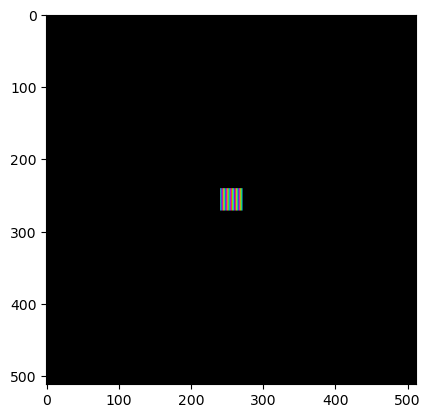

In [20]:
plt.imshow(colorize(U_box[0,...]))

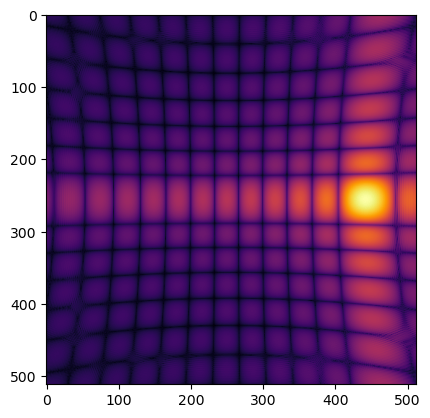

In [21]:
plt.imshow(((jnp.abs(0.0 + U_prop)**2)**0.13)[0,...], cmap="inferno")

In [8]:
N_box = 512
L_box = 128; # µm
lbd = 0.5
shape = (N_box, N_box)
kx = 2 * jnp.pi / lbd * np.sin(20/ 360 * 2 * jnp.pi)
field = cx.plane_wave(shape=shape, dx=L_box/N_box, spectrum=lbd, spectral_density=1.0, kykx=[0,kx]) / 0.0078125

D_box = L_box / 16
field = cx.square_pupil(field, w=D_box)



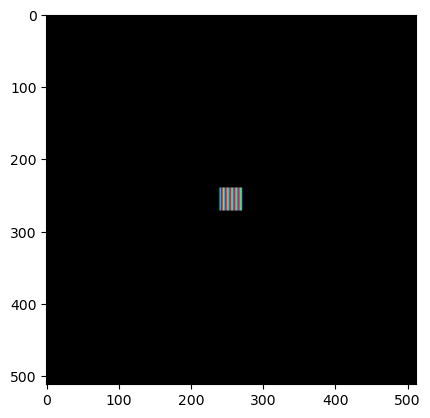

In [22]:
plt.imshow(colorize(field.u[0,:,:,0,0]))
#plt.imshow(field.phase.squeeze(), cmap="afmhot")
#plt.axis("off")
#plt.show()

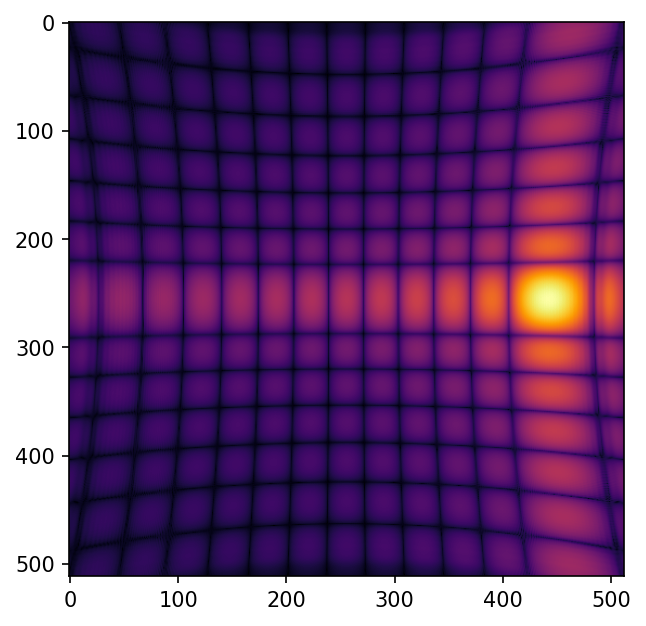

In [11]:
M_box = 8;          
z_box = M_box / N_box / lbd * L_box**2 * 2
# field_p = cx.propagation.transform_propagate(field, z=z_box, N_pad = (256, 256), n=1.0)
field_p = jax.jit(cx.propagation.transform_propagate_sas)(field, z=z_box, n=1.0)

fig = plt.figure(dpi=150)
# plt.imshow(field_p.intensity.squeeze(), cmap="afmhot")
# plt.axis("off")
plt.imshow(((field_p.intensity.squeeze())**0.13), cmap="inferno")
plt.show()
# plt.imshow(colorize(field_p.u[0,:,:,0,0] )) # / jnp.max(field_p.u[0,:,:,0,0])
# jnp.max(abs(field_p + 0))

In [12]:
sas = jax.jit(scalable_angular_spectrum)

In [13]:
%%timeit
jax.block_until_ready(sas(U_box, z_box, lbd, L_box))

3.09 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
